In [1]:
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns
import hddm 
from patsy import dmatrix 
import numpy as np
from sys import platform
# print(hddm.__version__)

%matplotlib inline
# plt.rcParams['figure.figsize'] = 30, 10

/home/krista/anaconda3/envs/hddm/lib/python3.5/site-packages/IPython/parallel.py:13: ShimWarning: The `IPython.parallel` package has been deprecated since IPython 4.0. You should import from ipyparallel instead.
  "You should import from ipyparallel instead.", ShimWarning)


## Pre-processing

In [2]:
if platform == 'linux':
    home = '/home/krista/'
elif platform == 'darwin': 
    home = '/Users/67981492/'

In [3]:
!pwd
write_dir = home + 'Dropbox/volatileValues/simple_rt_experiment_probabilityC/analysis/hddm_reg_models/'

/home/krista/Dropbox/volatileValues/simple_rt_experiment_probabilityC/analysis/analysis_nbs


In [4]:
all_sim_data = hddm.load_csv(home + 'Dropbox/volatileValues/simple_rt_experiment_probabilityC/analysis/aggregated_data/probC_sim_learning_signals.csv')

In [5]:
all_sim_data.head(10)

cpp   target_B   choice_B   cp   gen_drift   gen_bound     rt    acc  \
0  0.025334   0.000000   0.000000    0    0.008505    0.246420  0.700  False   
1  0.022106   0.000000   0.000000    0    0.008505    0.525334  0.700  False   
2  0.020935   0.038001  -0.038001    0    0.008505    0.522106  0.700  False   
3  0.020345   0.070320  -0.070320    0    0.046506    0.520935  0.700  False   
4  0.646769   0.100251  -0.100251    0    0.116826    0.520345  0.700  False   
5  0.072232   0.128728  -0.128728    0    0.217077    1.146769  0.700  False   
6  0.026769  -1.359791   1.359791    0    0.345805    0.572232  0.700  False   
7  0.022626   0.398651  -0.398651    0    1.000000    0.526769  0.182  False   
8  0.021194   0.701844  -0.701844    0    0.601349    0.522626  0.222  False   
9  0.020494   0.829371  -0.829371    0    0.100495    0.521194  0.700  False   

    subj_idx   ID  cond  
0          0  761    lc  
1          0  761    lc  
2          0  761    lc  
3          0  761    lc  
4          0  761    lc  
5          0  761    lc  
6          0  761    lc  
7          0  761    lc  
8          0  761    lc  
9          0  761    lc

In [6]:
all_sim_data.columns = all_sim_data.columns.str.strip()
all_sim_data.head()
all_sim_data = all_sim_data[all_sim_data.rt<0.6]
all_sim_data.reset_index(drop=True, inplace=True)

In [7]:
all_sim_data = all_sim_data.rename(index=str, columns={"acc": "response"})
all_sim_data = all_sim_data[['response', 'rt', 'cond', 'subj_idx', 'choice_B', 'cpp']] 
all_sim_data = all_sim_data.rename(index=str, columns={'choice_B': 'B'})

In [8]:
all_sim_data['cond'] = all_sim_data['cond'].str.strip()
all_sim_data.head()

response     rt cond  subj_idx         B       cpp
0     False  0.182   lc         0 -0.398651  0.022626
1     False  0.222   lc         0 -0.701844  0.021194
2      True  0.352   lc         0 -0.902289  0.408017
3      True  0.342   lc         0 -1.914075  0.023195
4      True  0.332   lc         0  2.340844  0.034013

In [9]:
np.unique(all_sim_data.subj_idx), np.unique(all_sim_data.cond)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23]),
 array(['hc', 'hv', 'lc', 'lv'], dtype=object))

In [10]:
all_sim_data = hddm.utils.flip_errors(all_sim_data)

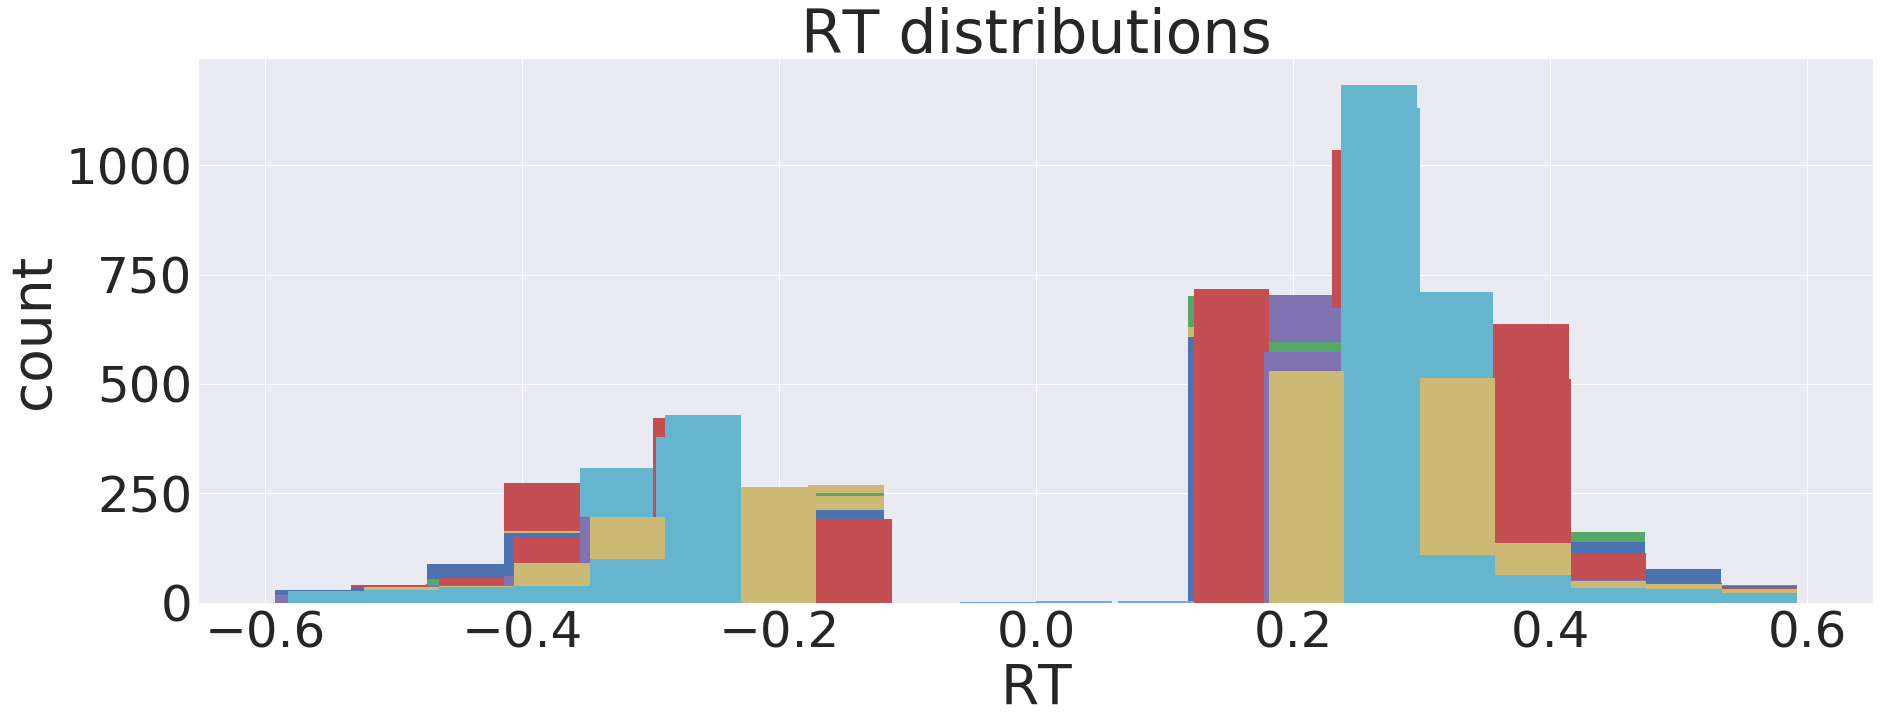

In [11]:
plt.rcParams['figure.figsize'] = 30, 10
sns.set(font_scale=5)
fig = plt.figure()
ax = fig.add_subplot(111, xlabel='RT', ylabel='count', title='RT distributions')
for i, subj_data in all_sim_data.groupby('subj_idx'):
    subj_data.rt.hist(bins=20, histtype='stepfilled', ax=ax)

In [12]:
all_sim_data.columns

Index(['response', 'rt', 'cond', 'subj_idx', 'B', 'cpp'], dtype='object')

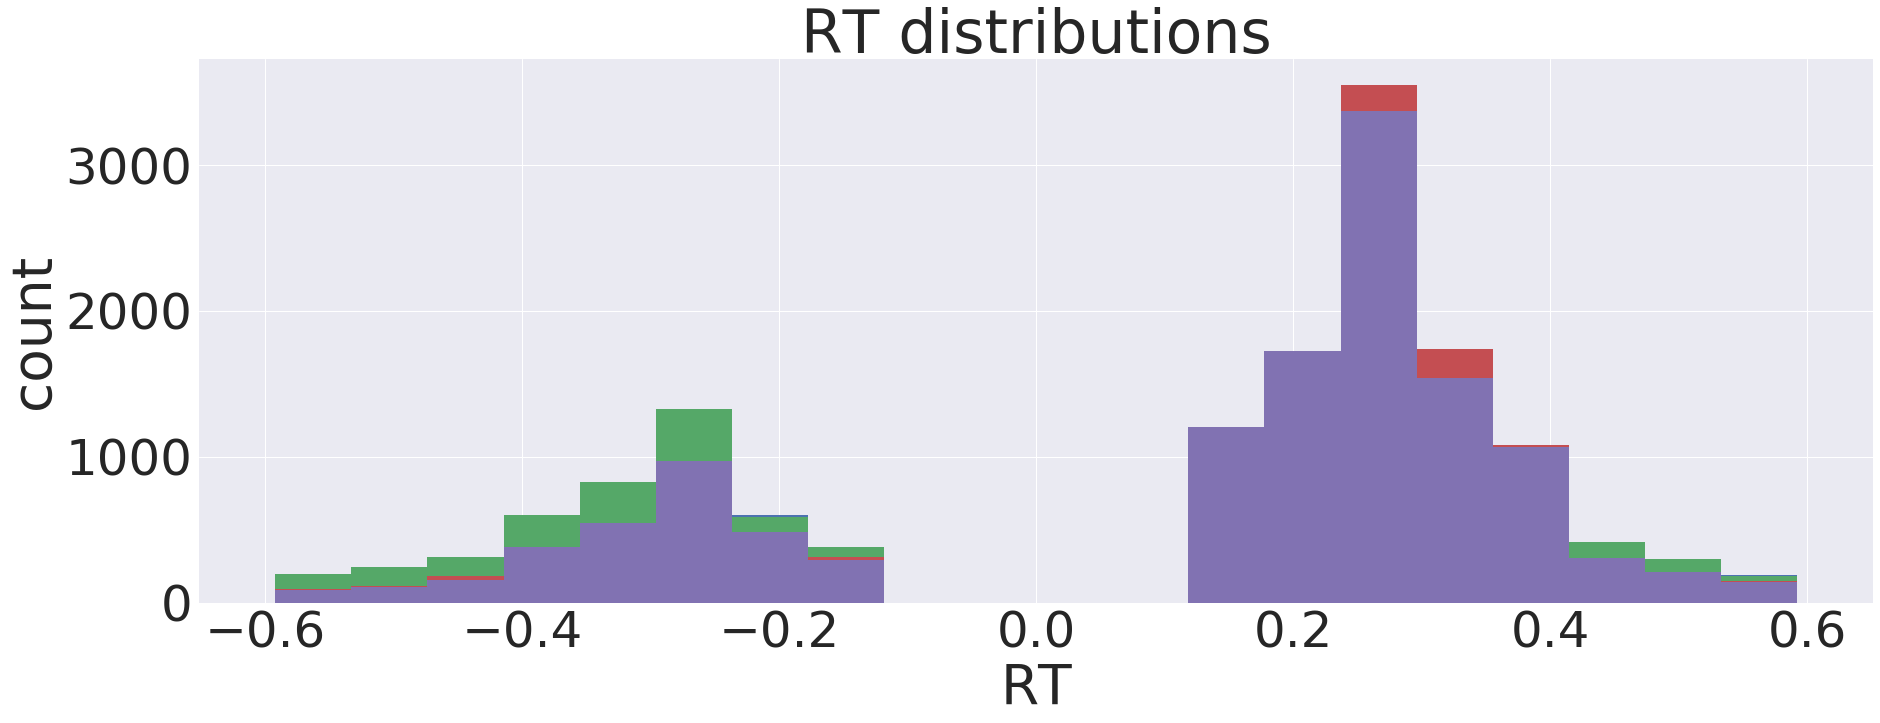

In [13]:
fig = plt.figure()
ax = fig.add_subplot(111, xlabel='RT', ylabel='count', title='RT distributions')
for i, subj_data in all_sim_data.groupby('cond'):
    subj_data.rt.hist(bins=20, histtype='stepfilled', ax=ax)

Text(0,0.5,'B')

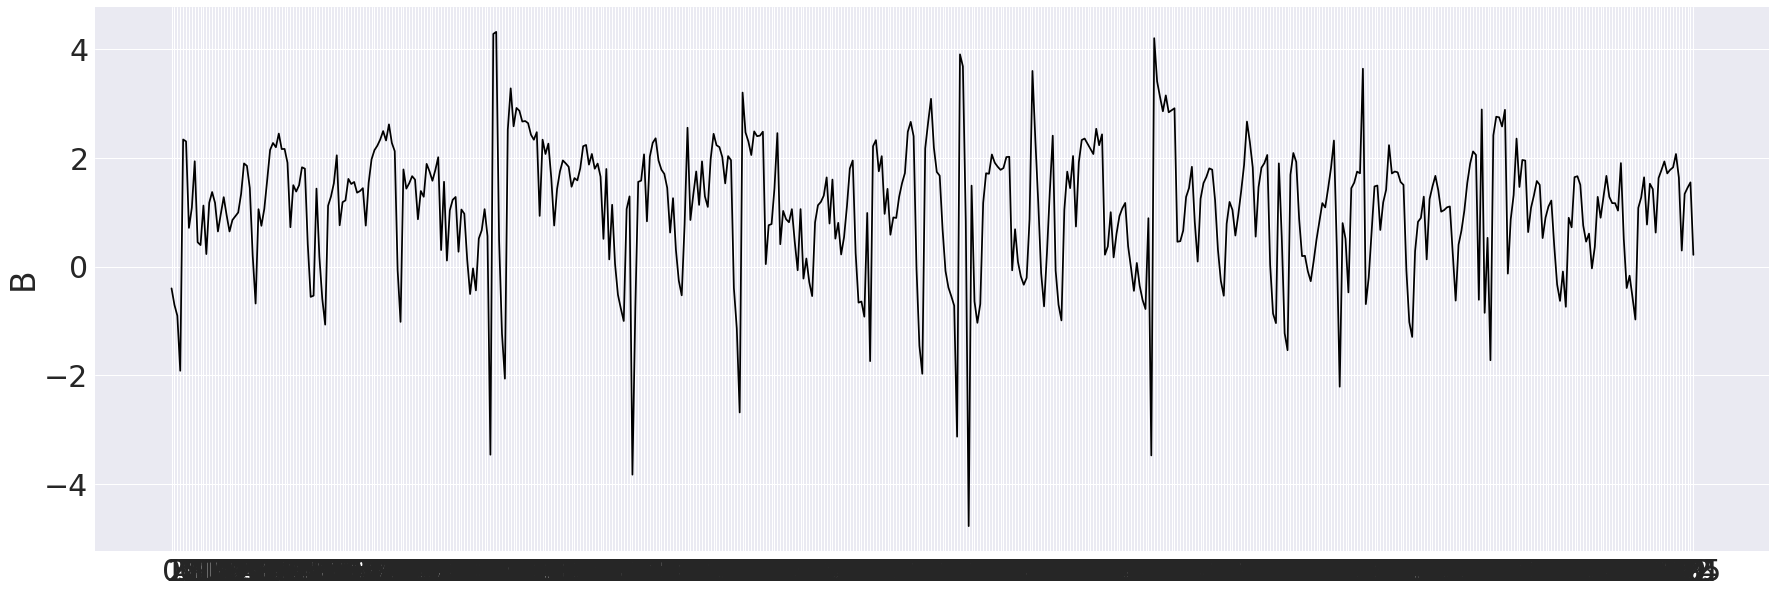

In [31]:
plt.plot(all_sim_data.B[(all_sim_data.subj_idx == 0) & (all_sim_data.cond == 'lc')], 'k')
plt.ylabel('B')

Text(0,0.5,'error-flipped rt')

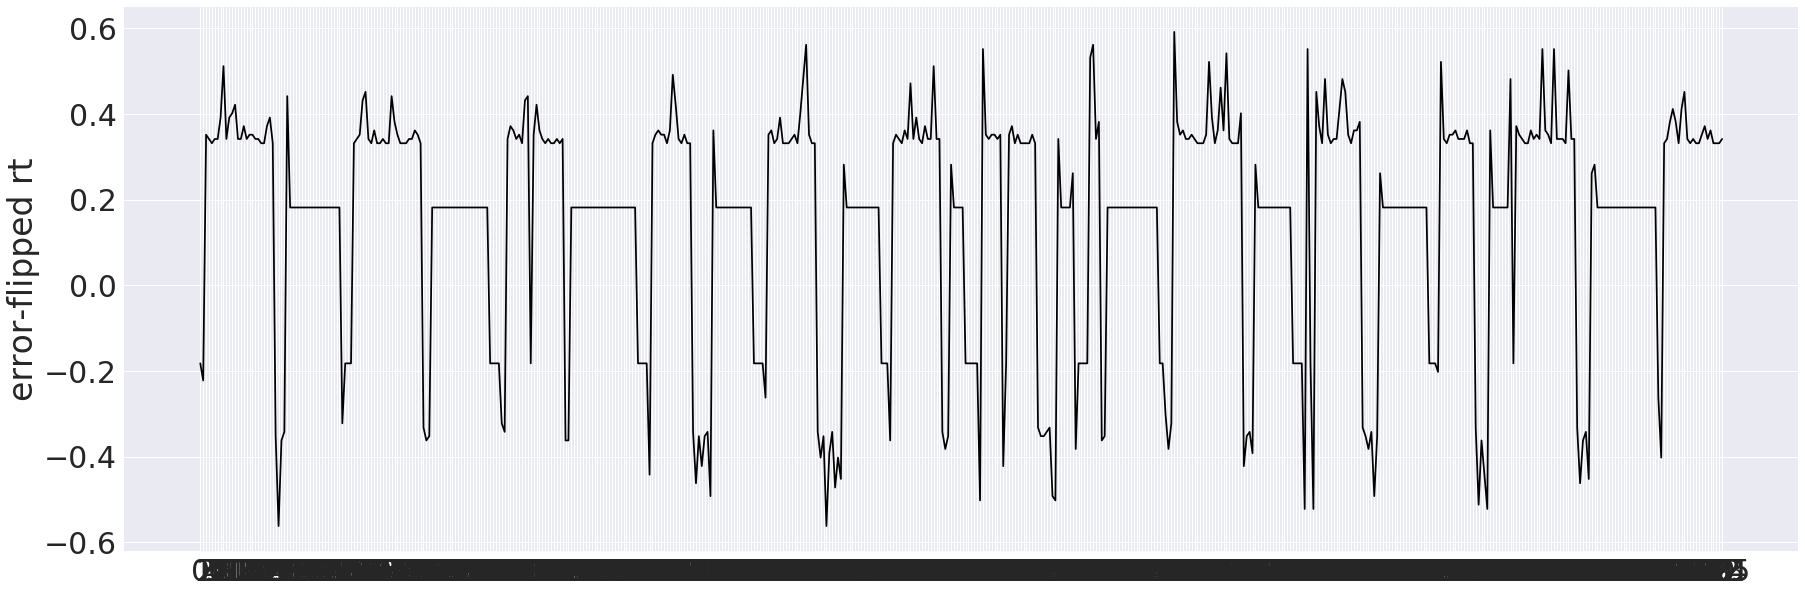

In [32]:
plt.plot(all_sim_data.rt[(all_sim_data.subj_idx == 0) & (all_sim_data.cond == 'lc')], 'k')
plt.ylabel('error-flipped rt')

Text(0,0.5,'cpp')

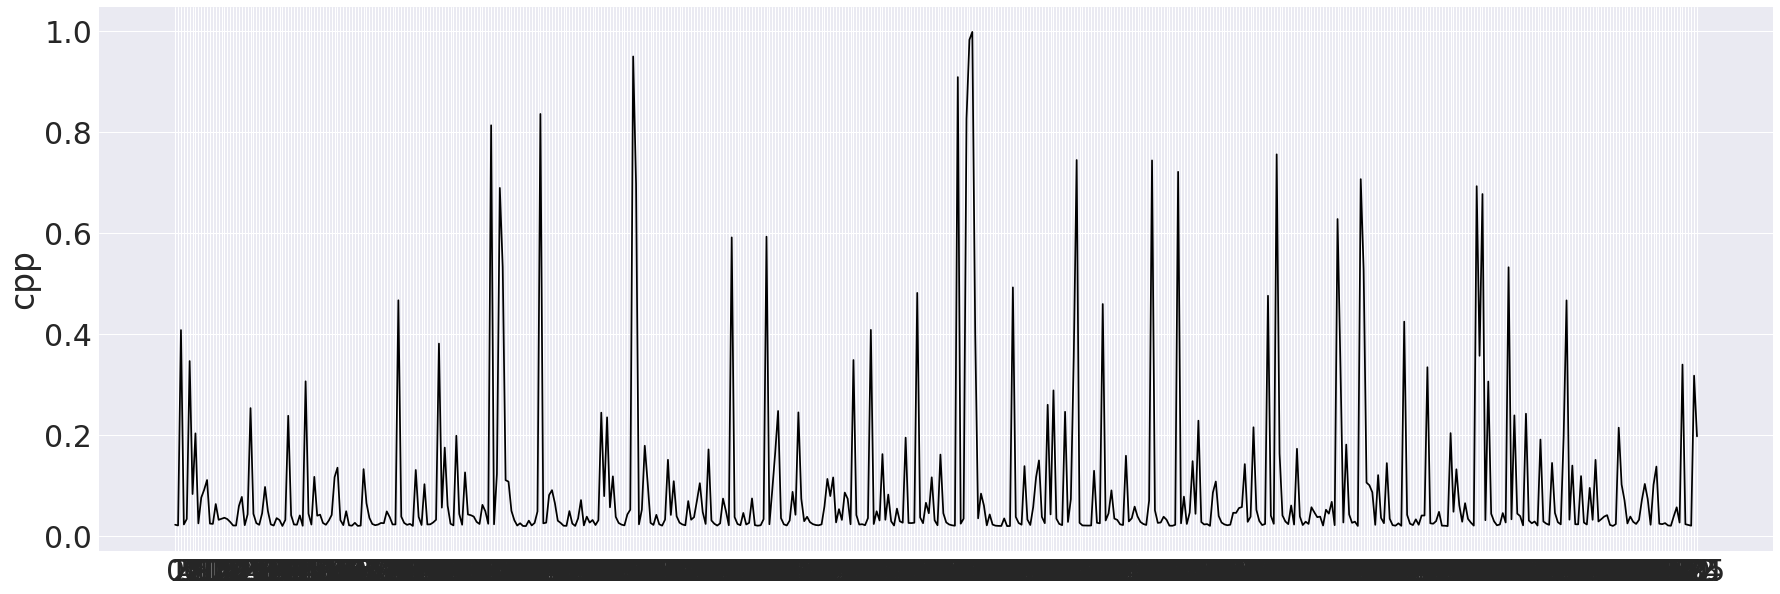

In [33]:
plt.plot(all_sim_data.cpp[(all_sim_data.subj_idx == 0) & (all_sim_data.cond == 'lc')], 'k')
plt.ylabel('cpp')

Text(0,0.5,'error-flipped accuracy')

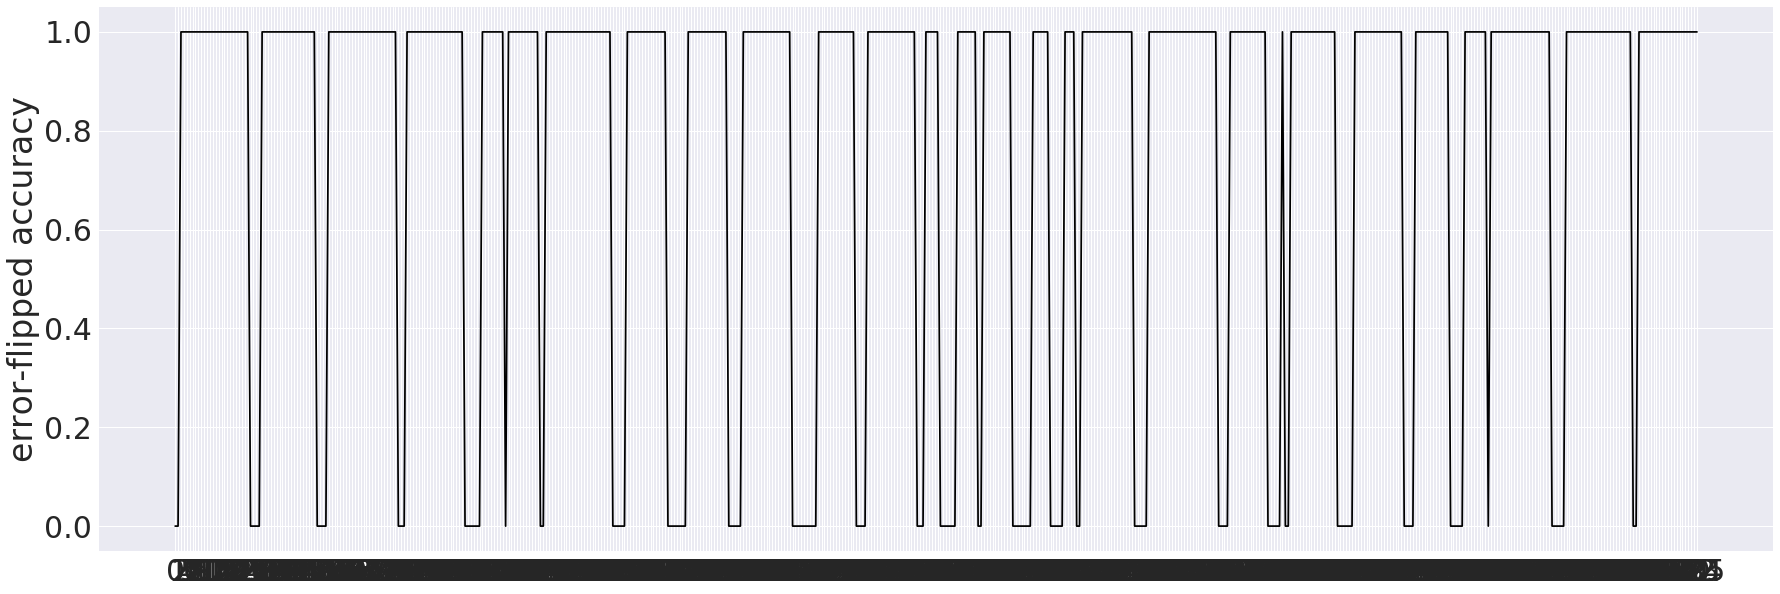

In [34]:
plt.plot(all_sim_data.response[(all_sim_data.subj_idx == 0) & (all_sim_data.cond == 'lc')], 'k')
plt.ylabel('error-flipped accuracy')

In [14]:
#learning signals
learning_signals =['cpp:C(cond)','B:C(cond)']
B = learning_signals[1]
cpp = learning_signals[0]
#targets
targets  = [ 'v ~ ', 'a ~ ', 't ~ ']
include=['v', 't', 'a', 'z']
v = targets[0]
a = targets[1]
tr = targets[2]

# n_samples, n_burned_samples = 1000, 50
n_samples, n_burned_samples = 1000, 50

In [15]:
v+B, a+cpp

('v ~ B:C(cond)', 'a ~ cpp:C(cond)')

#### v,a,t -> b 

In [16]:
v_a_t_B_subj_sim_reg = hddm.HDDMRegressor(all_sim_data,[v+B, a+B, tr+B],bias=False, include=include, informative=True)
v_a_t_B_subj_sim_reg.sample(n_samples,burn=n_burned_samples,dbname='v_a_t_B_subj_sim_reg_TEST.db', db='pickle')

Adding these covariates:
['v_Intercept', 'v_B:C(cond)[hc]', 'v_B:C(cond)[hv]', 'v_B:C(cond)[lc]', 'v_B:C(cond)[lv]']
Adding these covariates:
['a_Intercept', 'a_B:C(cond)[hc]', 'a_B:C(cond)[hv]', 'a_B:C(cond)[lc]', 'a_B:C(cond)[lv]']
Adding these covariates:
['t_Intercept', 't_B:C(cond)[hc]', 't_B:C(cond)[hv]', 't_B:C(cond)[lc]', 't_B:C(cond)[lv]']


/home/krista/anaconda3/envs/hddm/lib/python3.5/site-packages/pymc/Node.py:403: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  self.__name__ = input['__name__']


 [-----------------100%-----------------] 1001 of 1000 complete in 8082.3 sec

/home/krista/anaconda3/envs/hddm/lib/python3.5/site-packages/numpy/core/fromnumeric.py:224: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return reshape(newshape, order=order)
/home/krista/anaconda3/envs/hddm/lib/python3.5/site-packages/numpy/core/fromnumeric.py:224: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return reshape(newshape, order=order)
/home/krista/anaconda3/envs/hddm/lib/python3.5/site-packages/numpy/core/fromnumeric.py:224: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return reshape(newshape, order=order)
/home/krista/anaconda3/envs/hddm/lib/python3.5/site-packages/numpy/core/fromnumeric.py:224: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return reshape(newshape, order=order)
/home/krista/ana

#### v,a -> b | t ->  cpp  

In [17]:
v_a_B_t_cpp_subj_sim_reg = hddm.HDDMRegressor(all_sim_data,[v+B, a+B, tr+cpp],bias=False, include=include, informative=True)
v_a_B_t_cpp_subj_sim_reg.sample(n_samples,burn=n_burned_samples,dbname='v_a_B_t_cpp_subj_sim_reg_TEST.db', db='pickle')

Adding these covariates:
['v_Intercept', 'v_B:C(cond)[hc]', 'v_B:C(cond)[hv]', 'v_B:C(cond)[lc]', 'v_B:C(cond)[lv]']
Adding these covariates:
['a_Intercept', 'a_B:C(cond)[hc]', 'a_B:C(cond)[hv]', 'a_B:C(cond)[lc]', 'a_B:C(cond)[lv]']
Adding these covariates:
['t_Intercept', 't_cpp:C(cond)[hc]', 't_cpp:C(cond)[hv]', 't_cpp:C(cond)[lc]', 't_cpp:C(cond)[lv]']


/home/krista/anaconda3/envs/hddm/lib/python3.5/site-packages/pymc/Node.py:403: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  self.__name__ = input['__name__']


 [-----------------100%-----------------] 1001 of 1000 complete in 9448.8 sec

/home/krista/anaconda3/envs/hddm/lib/python3.5/site-packages/numpy/core/fromnumeric.py:224: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return reshape(newshape, order=order)
/home/krista/anaconda3/envs/hddm/lib/python3.5/site-packages/numpy/core/fromnumeric.py:224: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return reshape(newshape, order=order)
/home/krista/anaconda3/envs/hddm/lib/python3.5/site-packages/numpy/core/fromnumeric.py:224: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return reshape(newshape, order=order)
/home/krista/anaconda3/envs/hddm/lib/python3.5/site-packages/numpy/core/fromnumeric.py:224: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return reshape(newshape, order=order)
/home/krista/ana

#### t -> cpp | v -> b  

In [18]:
t_cpp_v_B_subj_sim_reg = hddm.HDDMRegressor(all_sim_data,[tr+cpp, v+B],bias=False, include=include, informative=True)
t_cpp_v_B_subj_sim_reg.sample(n_samples,burn=n_burned_samples,dbname='t_cpp_v_B_subj_sim_reg_TEST.db', db='pickle')

Adding these covariates:
['t_Intercept', 't_cpp:C(cond)[hc]', 't_cpp:C(cond)[hv]', 't_cpp:C(cond)[lc]', 't_cpp:C(cond)[lv]']
Adding these covariates:
['v_Intercept', 'v_B:C(cond)[hc]', 'v_B:C(cond)[hv]', 'v_B:C(cond)[lc]', 'v_B:C(cond)[lv]']


/home/krista/anaconda3/envs/hddm/lib/python3.5/site-packages/pymc/Node.py:403: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  self.__name__ = input['__name__']


 [-----------------100%-----------------] 1001 of 1000 complete in 5347.4 sec

/home/krista/anaconda3/envs/hddm/lib/python3.5/site-packages/numpy/core/fromnumeric.py:224: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return reshape(newshape, order=order)
/home/krista/anaconda3/envs/hddm/lib/python3.5/site-packages/numpy/core/fromnumeric.py:224: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return reshape(newshape, order=order)
/home/krista/anaconda3/envs/hddm/lib/python3.5/site-packages/numpy/core/fromnumeric.py:224: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return reshape(newshape, order=order)
/home/krista/anaconda3/envs/hddm/lib/python3.5/site-packages/numpy/core/fromnumeric.py:224: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return reshape(newshape, order=order)
/home/krista/ana

In [19]:
dics = [v_a_t_B_subj_sim_reg.dic, v_a_B_t_cpp_subj_sim_reg.dic, t_cpp_v_B_subj_sim_reg.dic]
m_names = ['v_a_t_B_subj_sim_reg', 'v_a_B_t_cpp_subj_sim_reg', 't_cpp_v_B_subj_sim_reg']

In [22]:
dics

[-62973.003578557138, -62975.378933928601, -62904.718390319365]

Text(0.5,1,'Sanity check: Fitting simulated data to top 3 regression models from observed data')

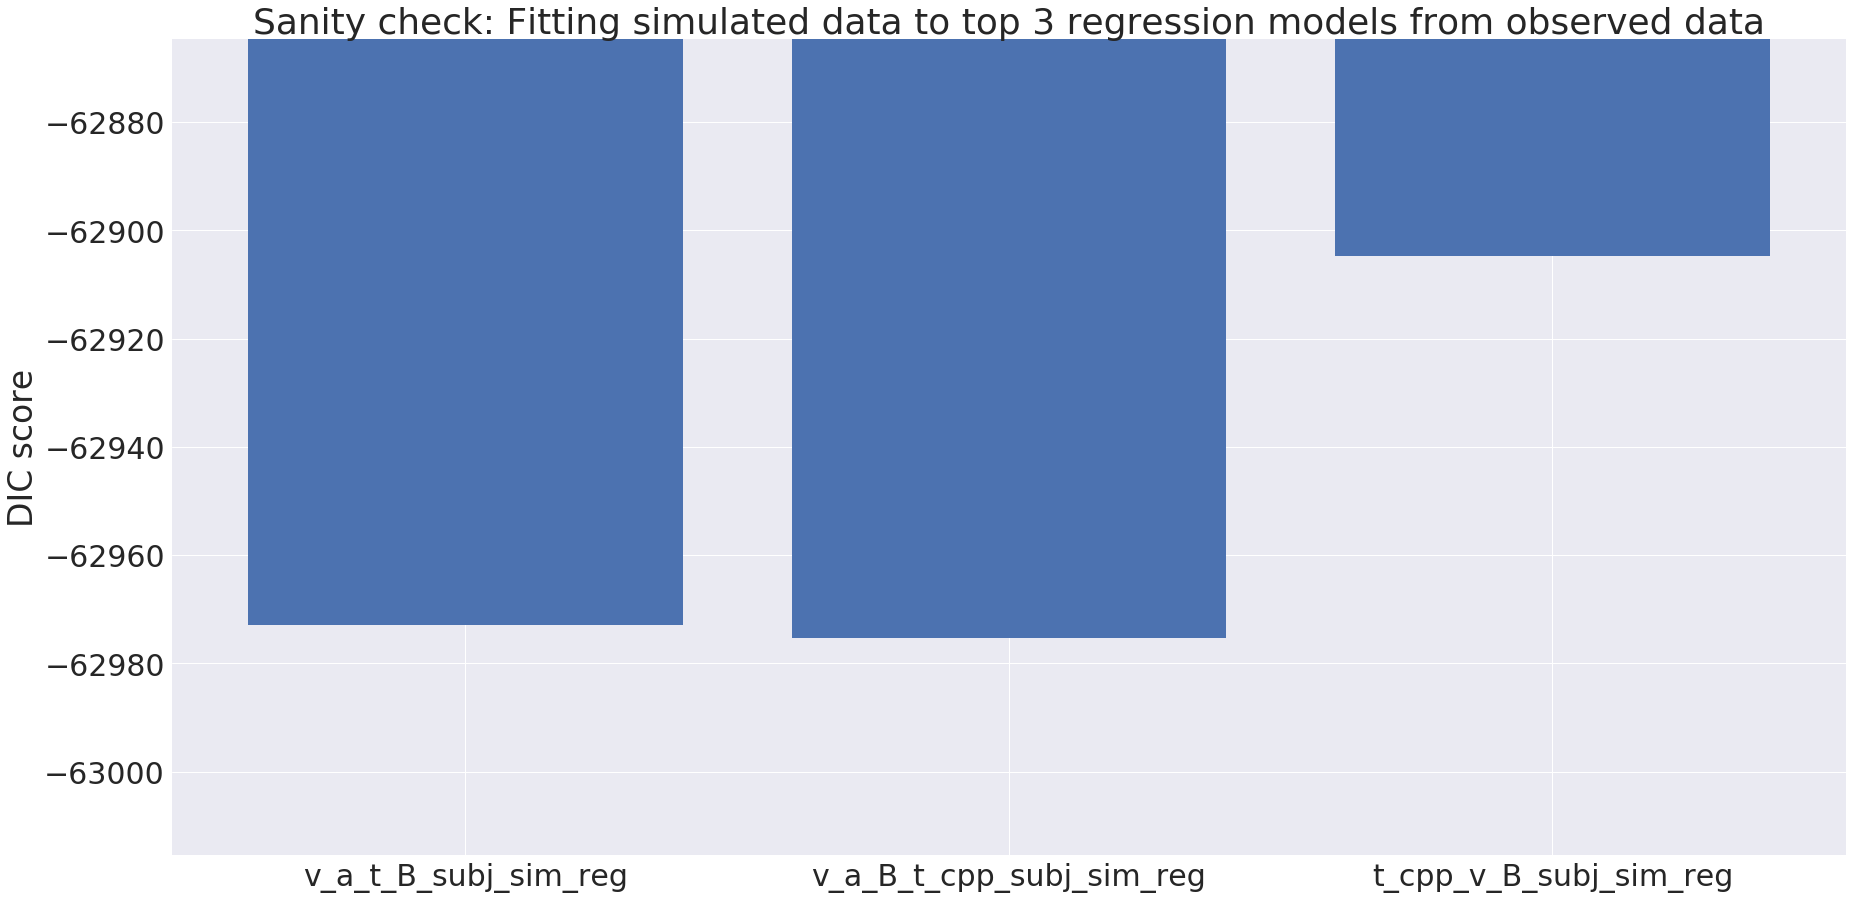

In [35]:
plt.figure(figsize=(30,15))
sns.set(font_scale=3)  
plt.bar(m_names, dics)
plt.ylabel('DIC score')
plt.ylim([min(dics) - 40, max(dics) + 40])
plt.title('Sanity check: Fitting simulated data to top 3 regression models from observed data')

In [24]:
dics

[-62973.003578557138, -62975.378933928601, -62904.718390319365]

In [25]:
min(dics)

-62975.378933928601

In [45]:
model_names_header = ', '.join(m_names)
print_dics_test_3_obs_models = np.column_stack(dics)
np.savetxt(write_dir+'sim_test_3_best_obs_models.csv', print_dics_test_3_obs_models, header=model_names_header, delimiter=',',comments='')

In [91]:
dics_test_gen_df = pd.read_csv(write_dir+'sim_test_gen_model.csv')
dics_test_3_best_obs_df = pd.read_csv(write_dir+'sim_test_3_best_obs_models.csv')
all_test_dics = pd.concat([dics_test_gen_df, dics_test_3_best_obs_df], axis=1)
all_test_dics.columns = all_test_dics.columns.str.strip()

In [92]:
all_test_dics

v_B & a_cpp   v_cpp & a_B  v_a_t_B_subj_sim_reg  v_a_B_t_cpp_subj_sim_reg  \
0 -63027.227225 -58746.650475         -62973.003579             -62975.378934   

   t_cpp_v_B_subj_sim_reg  
0            -62904.71839

In [97]:
#get rid of switched gen. model for these purposes -- just comparing generative
#& top 3 observed regression models
all_test_dics = all_test_dics.drop(['v_cpp & a_B'], axis=1)

#use consistent naming scheme 
all_test_dics = all_test_dics.rename(index=str, columns={"v_a_t_B_subj_sim_reg": "v_a_t_B", 
                              "v_a_B_t_cpp_subj_sim_reg": "v_a_B & t_cpp",
                             "t_cpp_v_B_subj_sim_reg": "t_cpp & v_B"})

Text(0.5,0,'regression model')

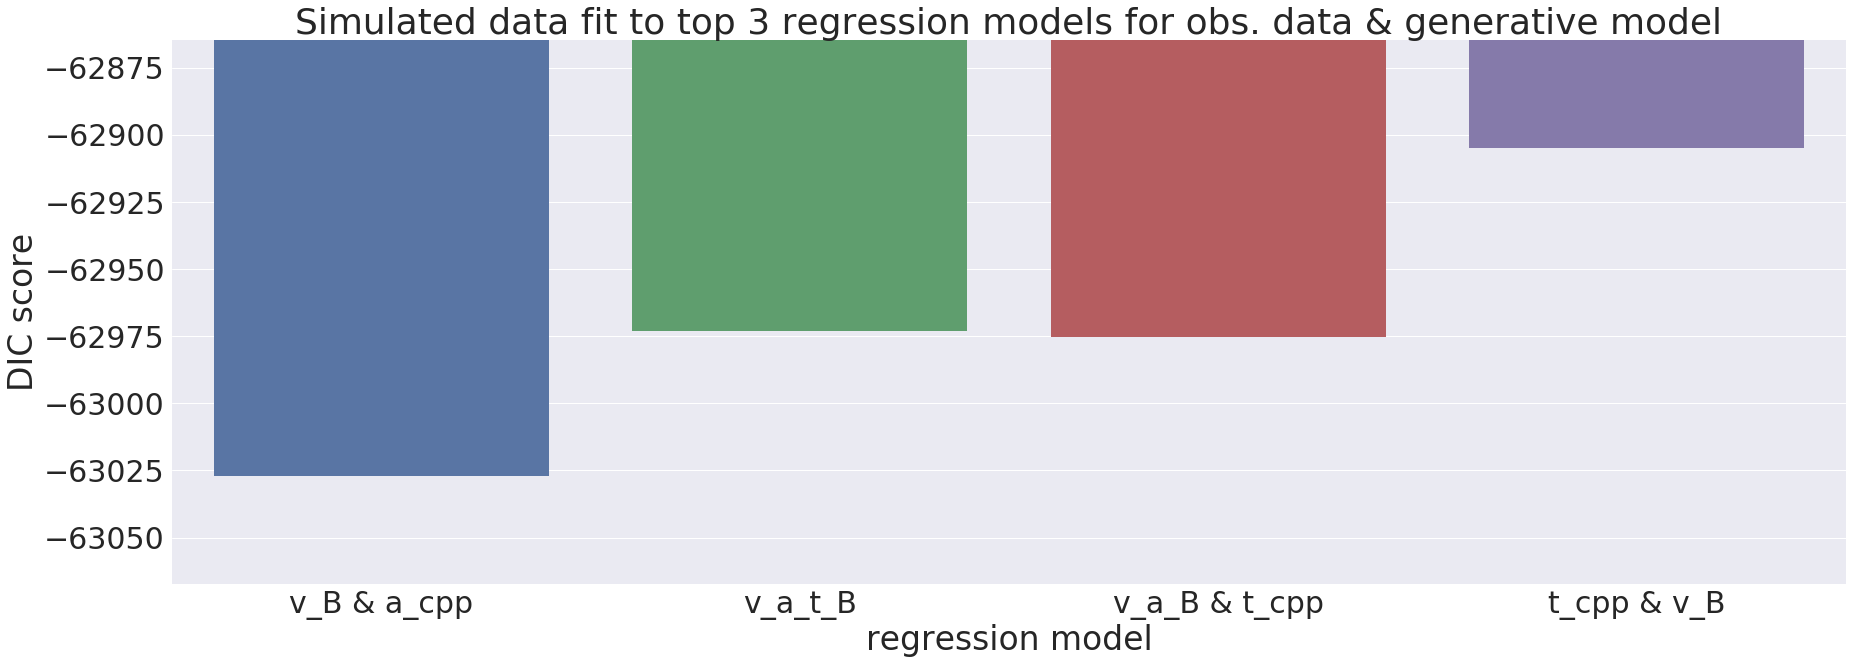

In [127]:
sns.barplot(data=all_test_dics)
plt.title("Simulated data fit to top 3 regression models for obs. data & generative model")
plt.ylim([all_test_dics.min(axis=1)[0] - 40, all_test_dics.max(axis=1)[0] + 40])
plt.ylabel('DIC score')
plt.xlabel('regression model')

In [117]:
all_test_dics

v_B & a_cpp       v_a_t_B  v_a_B & t_cpp  t_cpp & v_B
0 -63027.227225 -62973.003579  -62975.378934 -62904.71839

In [116]:
worst_model, winning_model = all_test_dics.idxmax(axis=1)[0], all_test_dics.idxmin(axis=1)[0]
print('winning model: ', winning_model, '\nworst model: ', worst_model)

winning model:  v_B & a_cpp 
worst model:  t_cpp & v_B


In [ ]:
plt.figure(figsize=(30,15))
sns.set(font_scale=3)  
plt.bar(m_names, dics)
plt.ylabel('DIC score')
plt.ylim([min(dics) - 40, max(dics) + 40])
plt.title('Sanity check: Fitting simulated data to top 3 regression models from observed data')

## Check convergence 

Plotting z
Plotting z_std
Plotting v_Intercept
Plotting v_Intercept_std
Plotting v_B:C(cond)[hc]
Plotting v_B:C(cond)[hv]
Plotting v_B:C(cond)[lc]
Plotting v_B:C(cond)[lv]
Plotting a_Intercept
Plotting a_Intercept_std
Plotting a_B:C(cond)[hc]
Plotting a_B:C(cond)[hv]
Plotting a_B:C(cond)[lc]
Plotting a_B:C(cond)[lv]
Plotting t_Intercept
Plotting t_Intercept_std
Plotting t_B:C(cond)[hc]
Plotting t_B:C(cond)[hv]
Plotting t_B:C(cond)[lc]
Plotting t_B:C(cond)[lv]


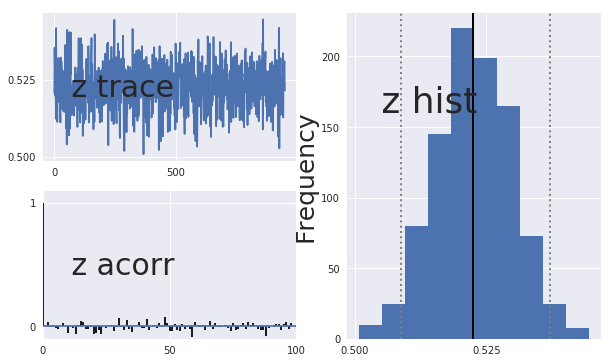

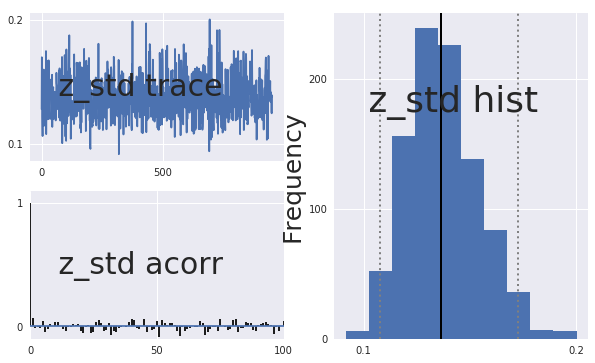

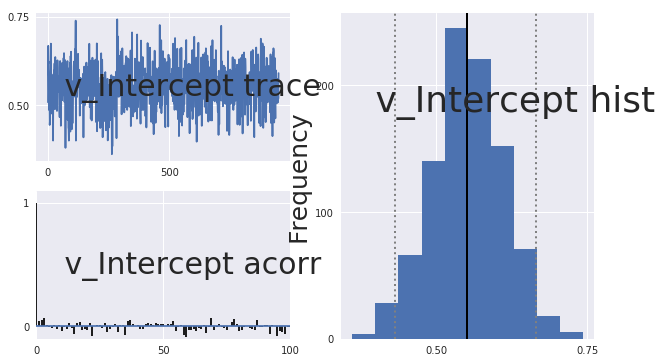

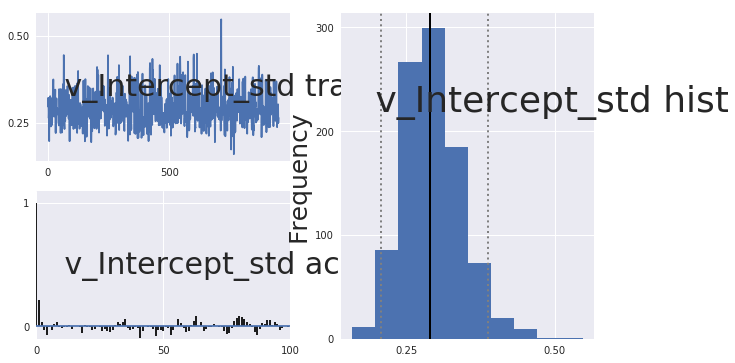

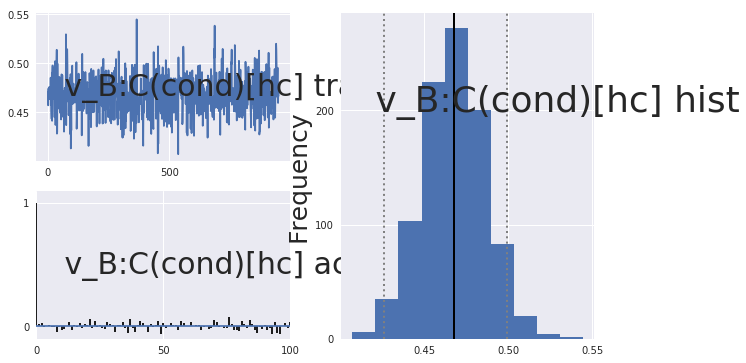

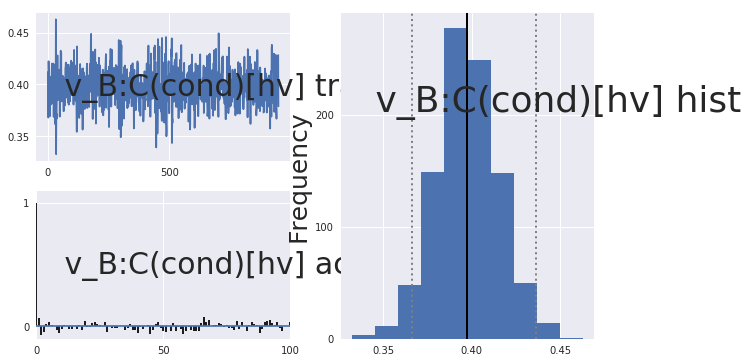

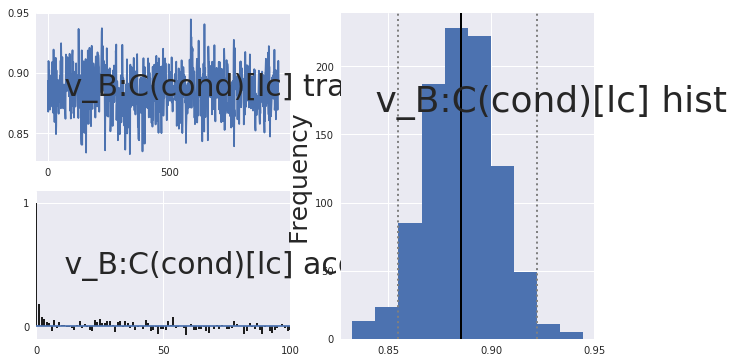

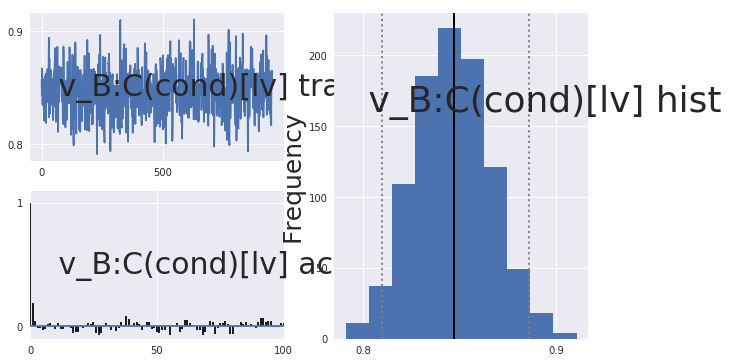

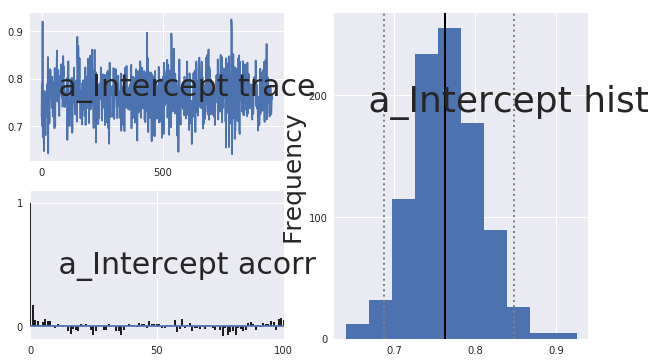

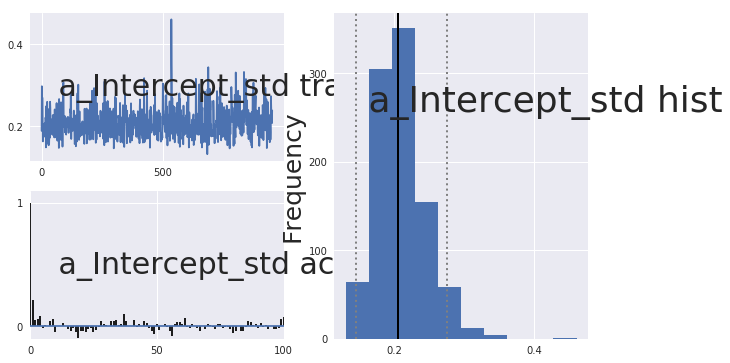

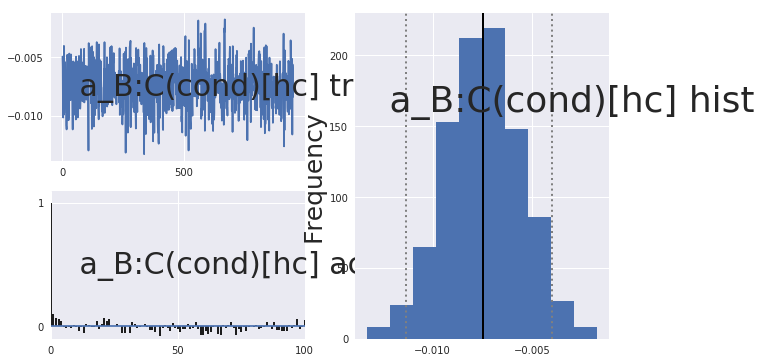

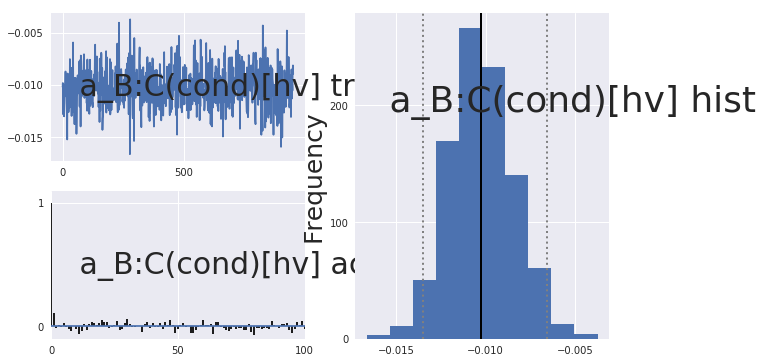

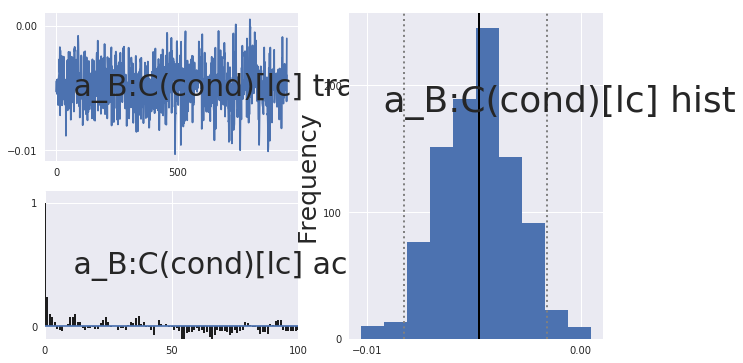

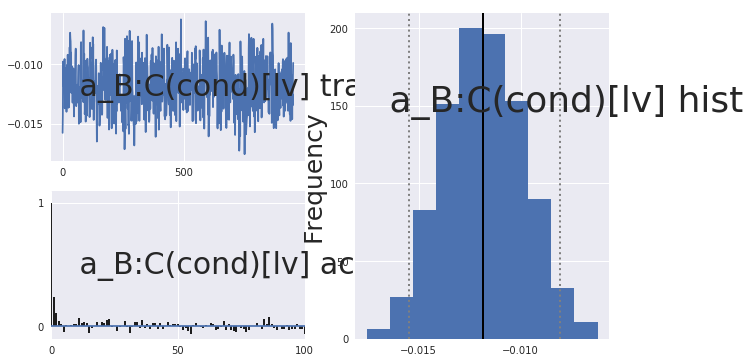

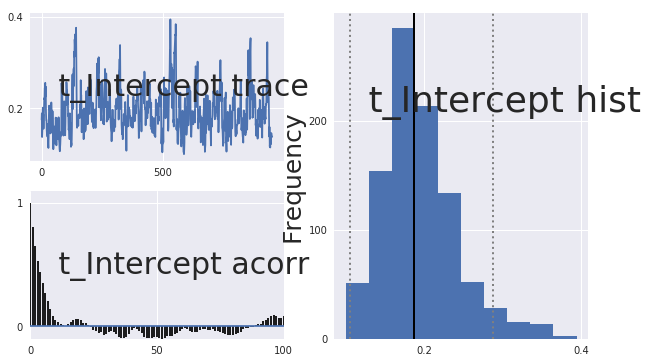

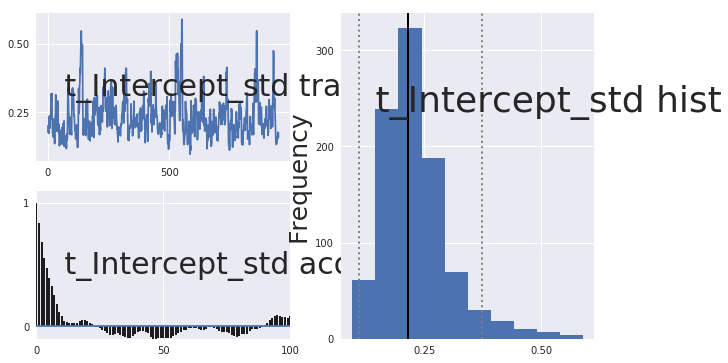

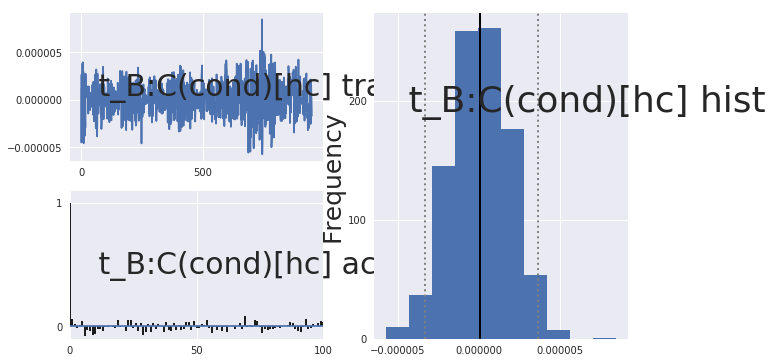

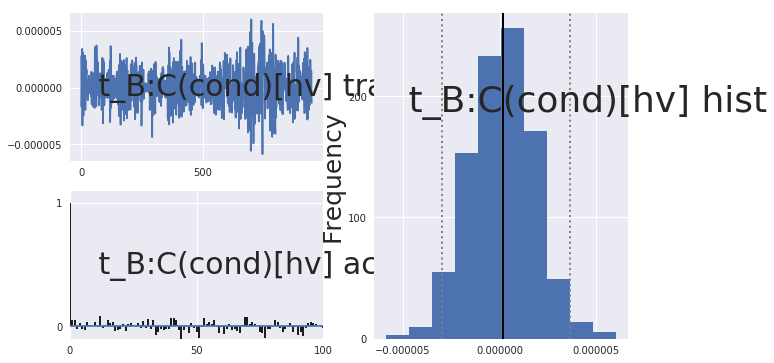

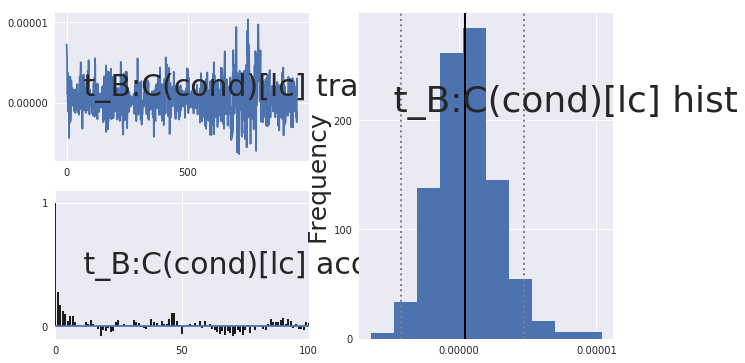

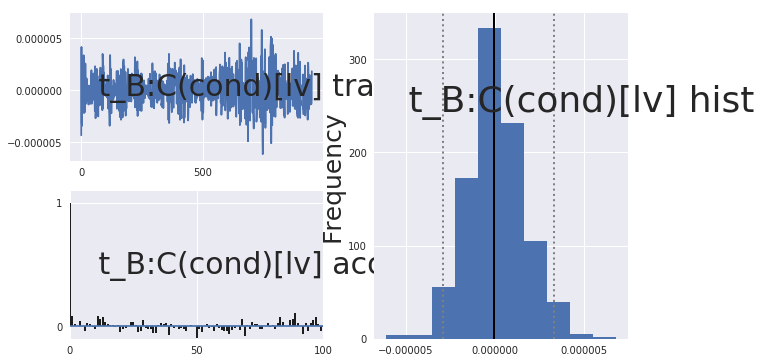

In [28]:
v_a_t_B_subj_sim_reg.plot_posteriors()

Plotting z
Plotting z_std
Plotting v_Intercept
Plotting v_Intercept_std
Plotting v_B:C(cond)[hc]
Plotting v_B:C(cond)[hv]
Plotting v_B:C(cond)[lc]
Plotting v_B:C(cond)[lv]
Plotting a_Intercept
Plotting a_Intercept_std
Plotting a_B:C(cond)[hc]
Plotting a_B:C(cond)[hv]
Plotting a_B:C(cond)[lc]
Plotting a_B:C(cond)[lv]
Plotting t_Intercept
Plotting t_Intercept_std
Plotting t_cpp:C(cond)[hc]
Plotting t_cpp:C(cond)[hv]
Plotting t_cpp:C(cond)[lc]
Plotting t_cpp:C(cond)[lv]


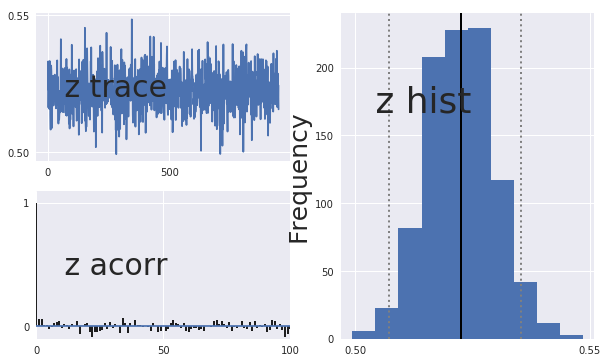

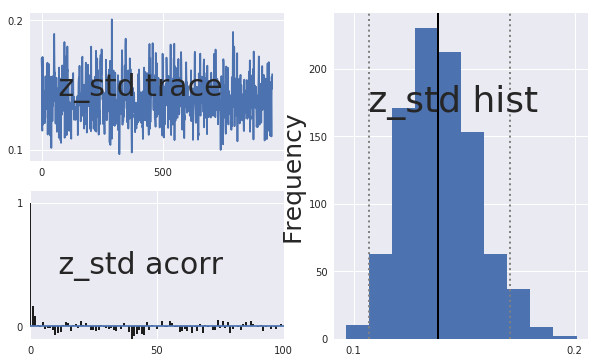

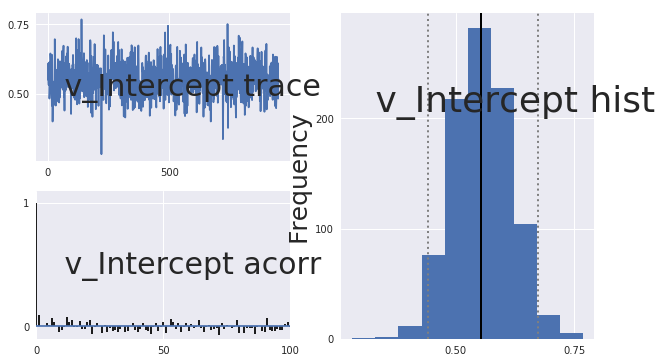

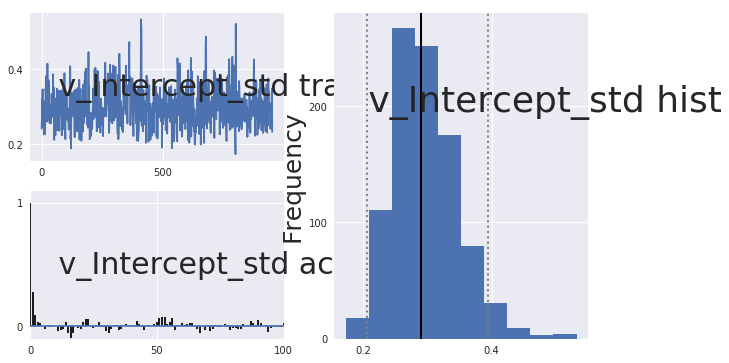

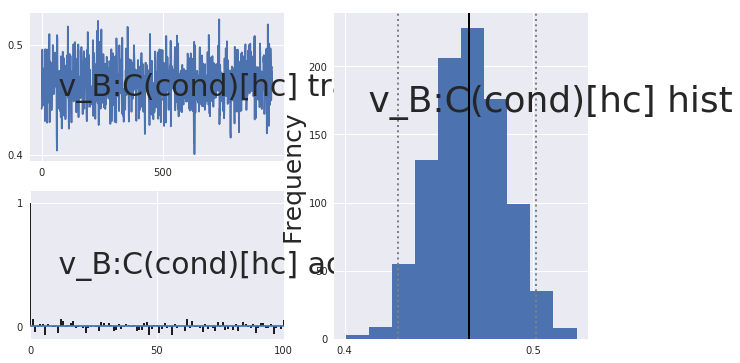

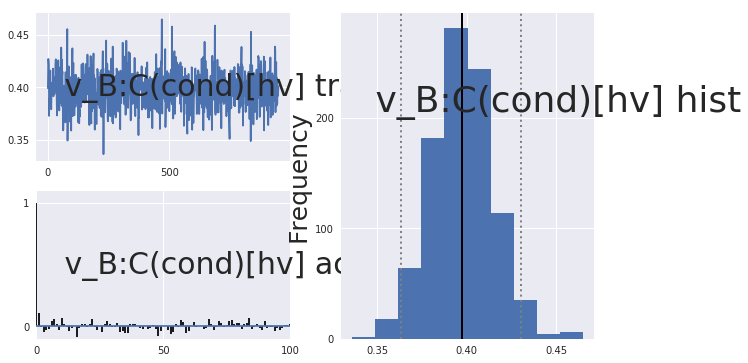

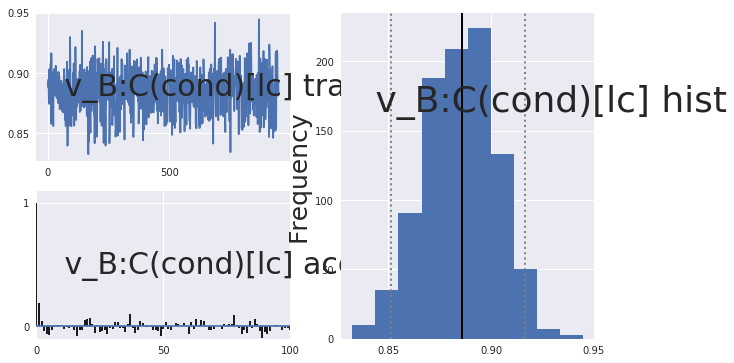

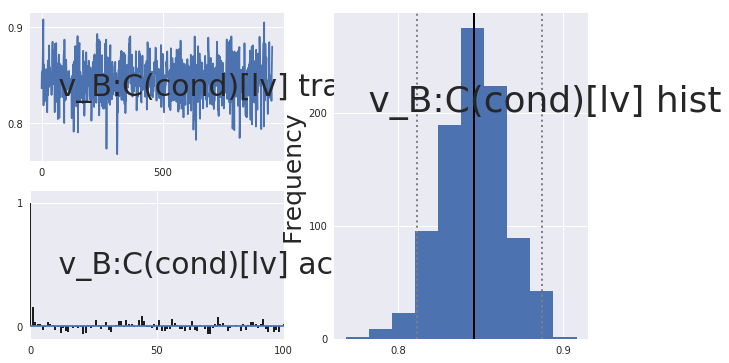

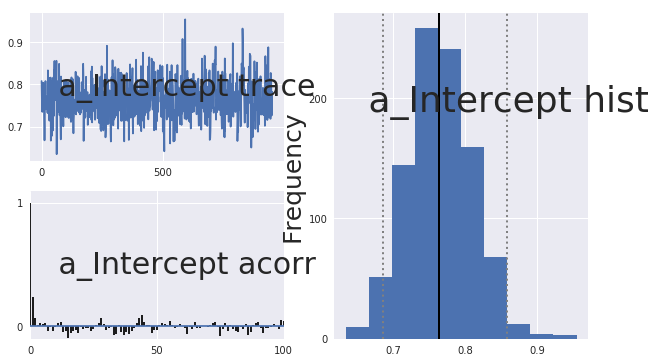

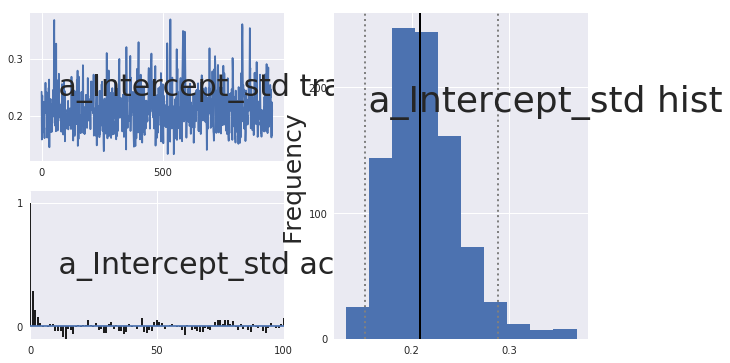

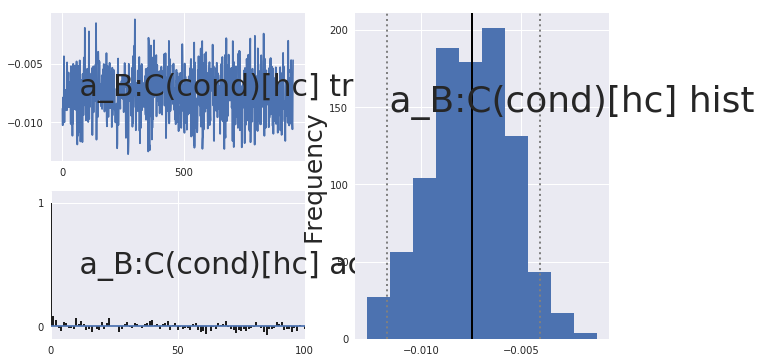

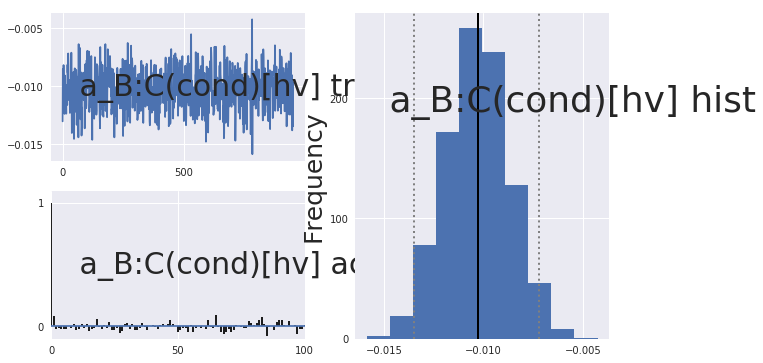

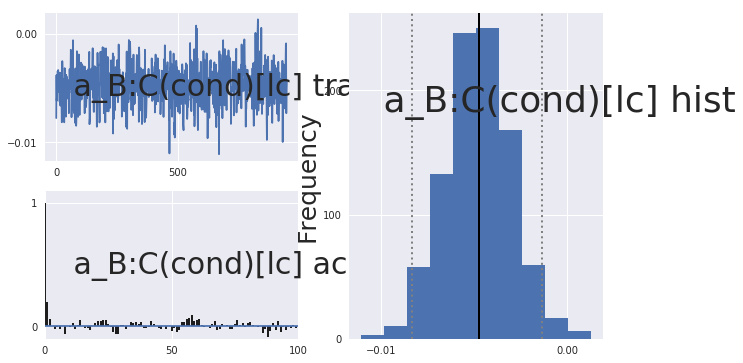

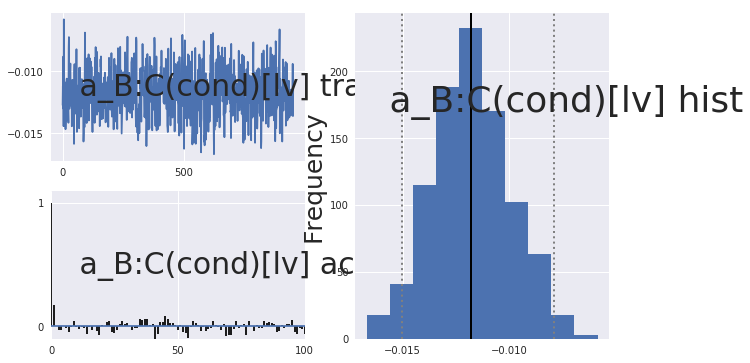

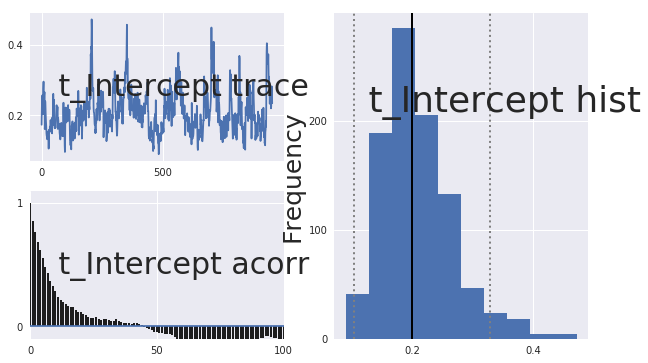

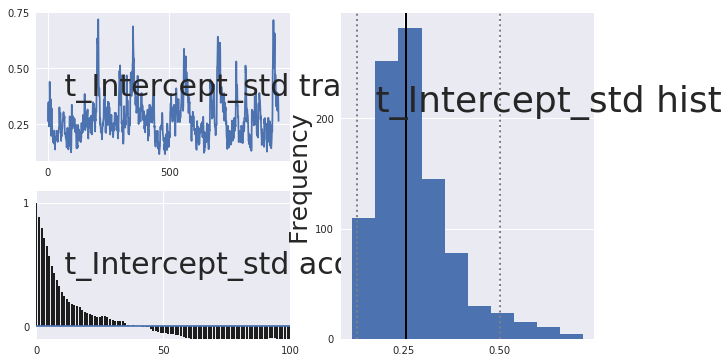

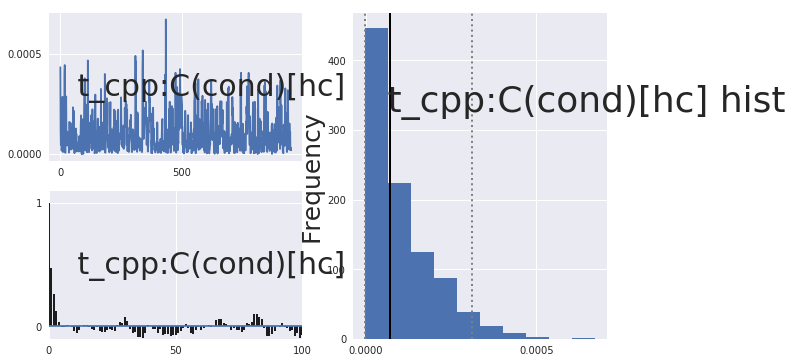

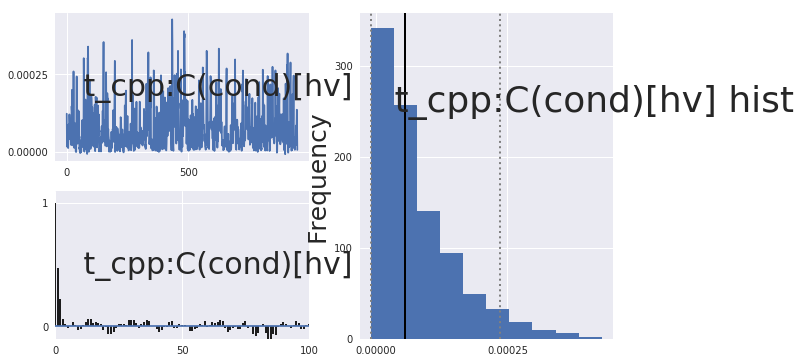

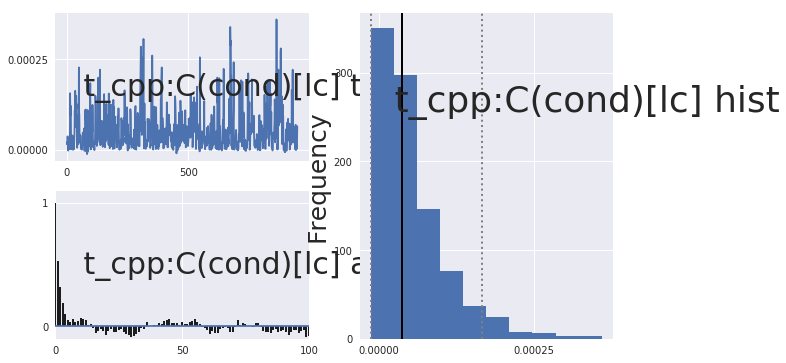

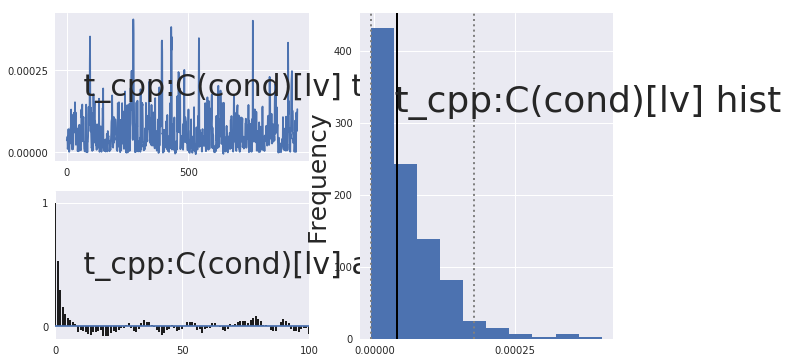

In [29]:
v_a_B_t_cpp_subj_sim_reg.plot_posteriors()

Plotting a
Plotting a_std
Plotting z
Plotting z_std
Plotting t_Intercept
Plotting t_Intercept_std
Plotting t_cpp:C(cond)[hc]
Plotting t_cpp:C(cond)[hv]
Plotting t_cpp:C(cond)[lc]
Plotting t_cpp:C(cond)[lv]
Plotting v_Intercept
Plotting v_Intercept_std
Plotting v_B:C(cond)[hc]
Plotting v_B:C(cond)[hv]
Plotting v_B:C(cond)[lc]
Plotting v_B:C(cond)[lv]


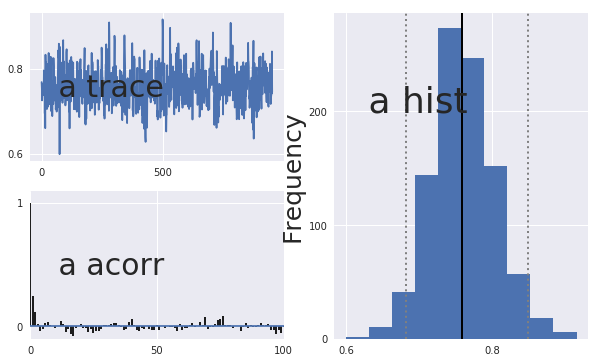

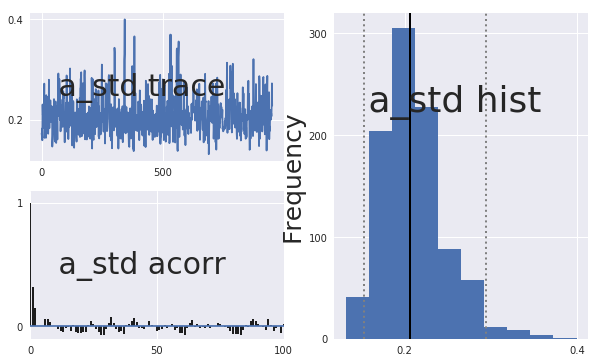

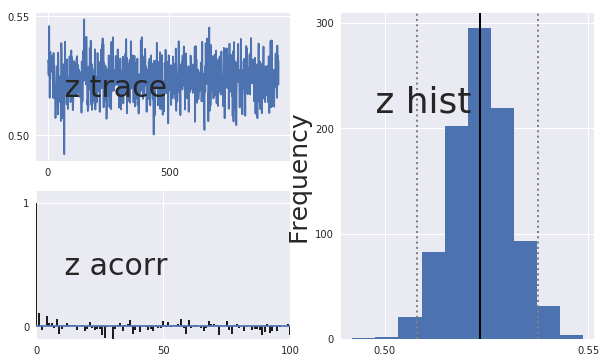

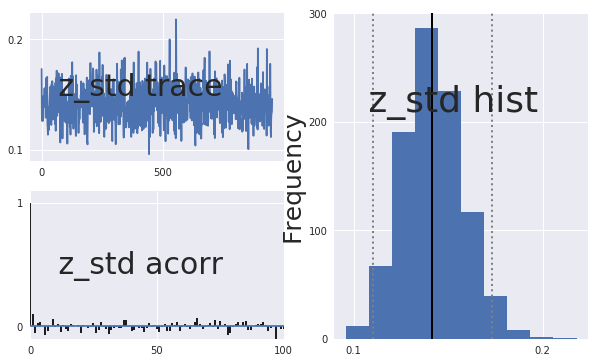

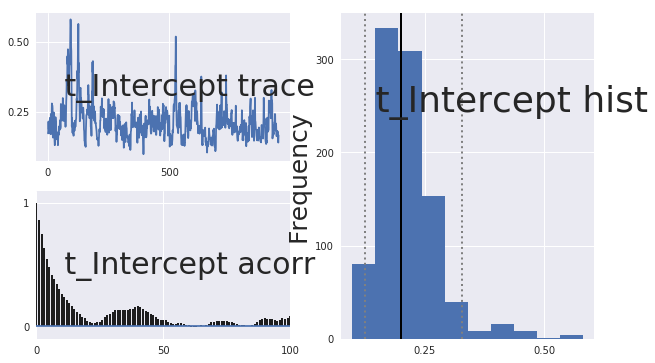

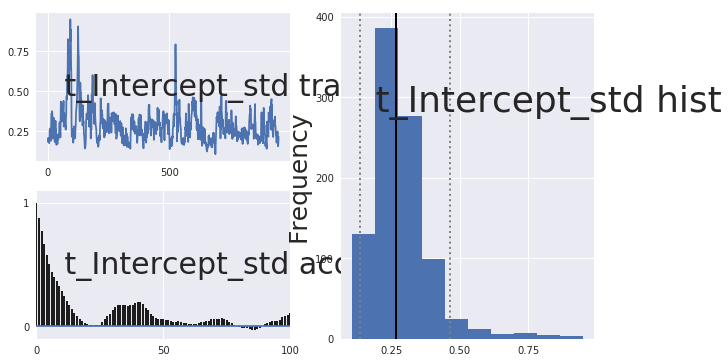

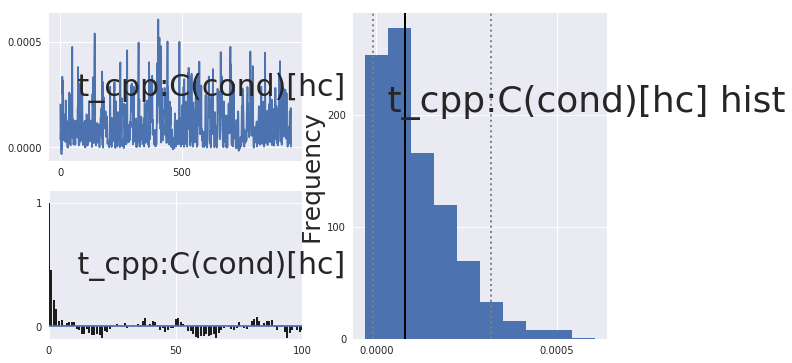

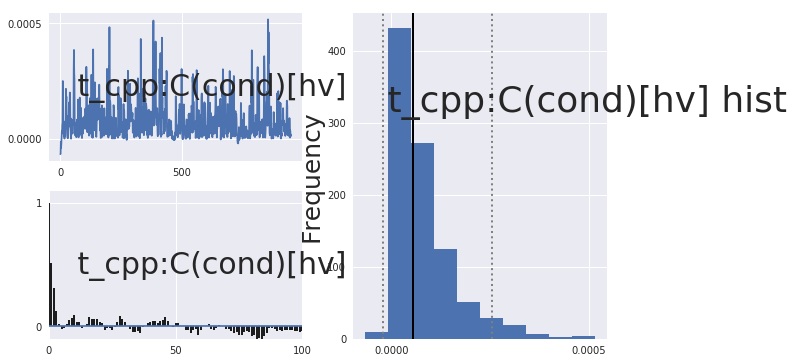

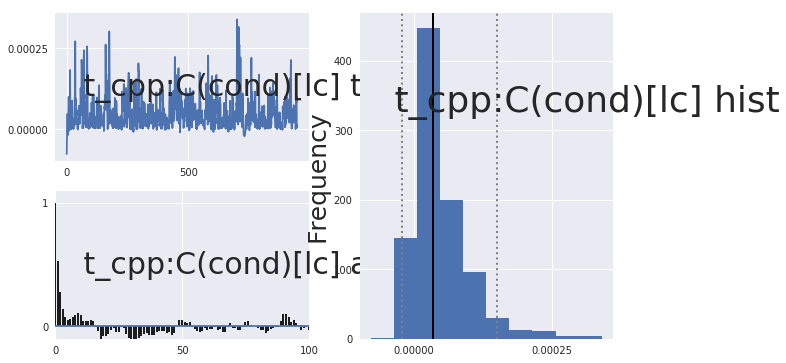

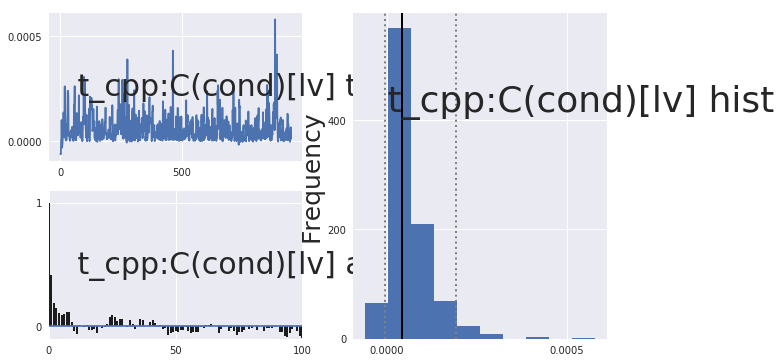

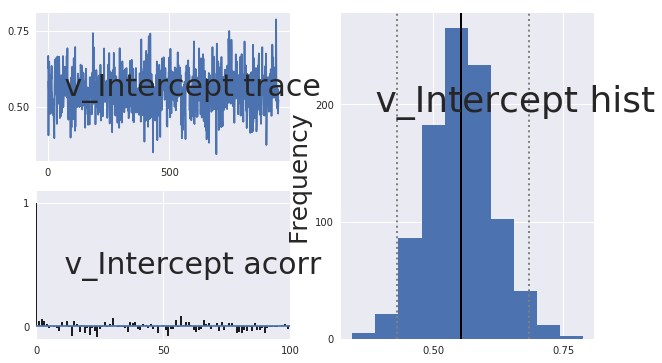

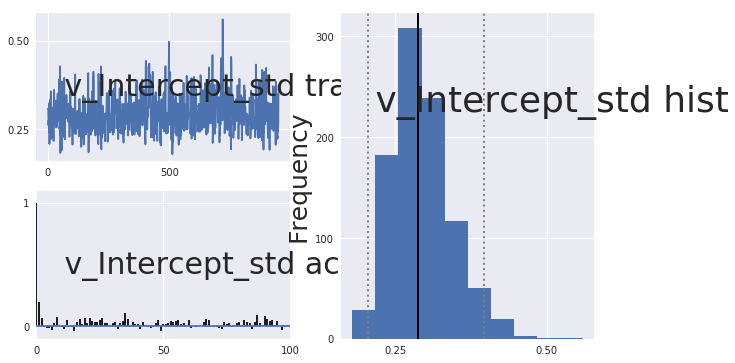

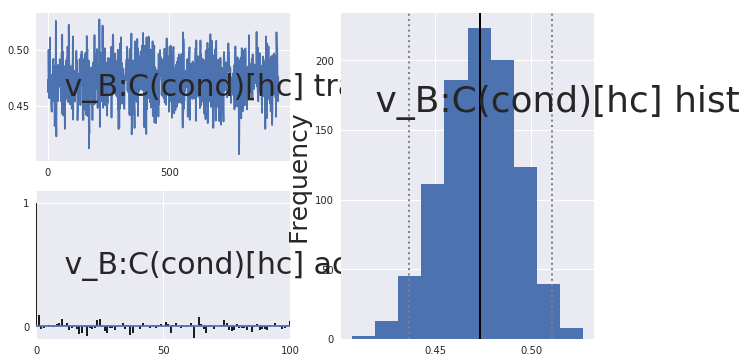

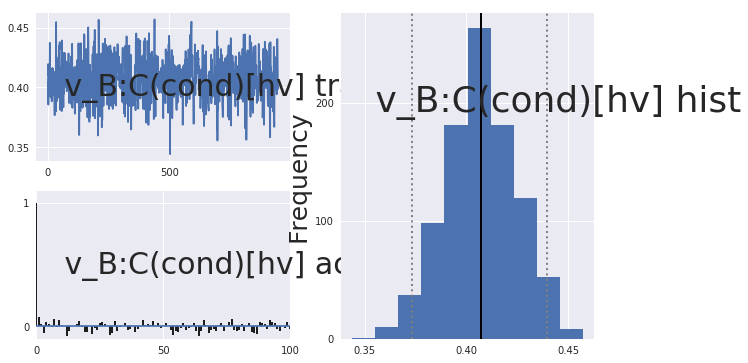

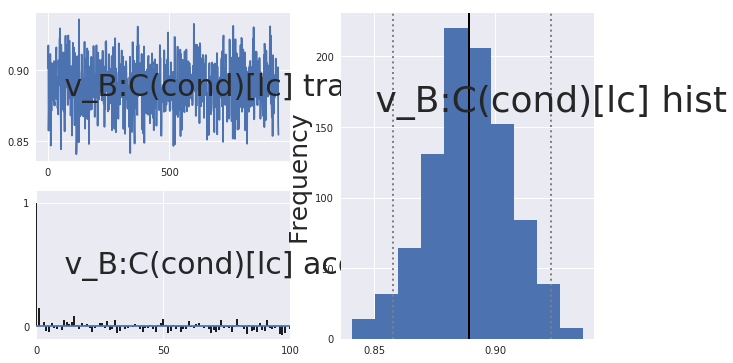

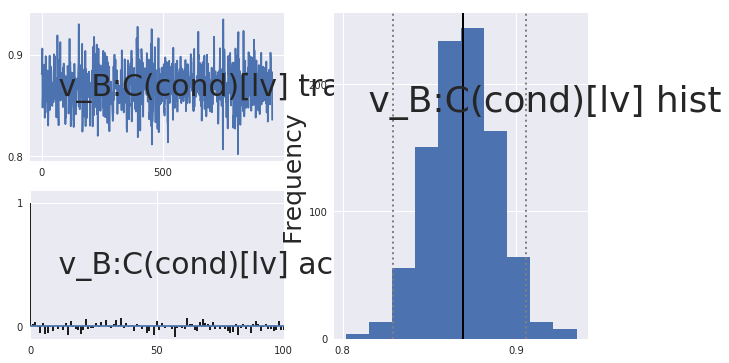

In [30]:
t_cpp_v_B_subj_sim_reg.plot_posteriors()